In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install surprise
import pandas as pd
import numpy as np
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163490 sha256=cde77bb277a38f53bda5137ff4685df887ea26bba5e3e73b28922067f661f9e4
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [3]:
# Load data
df_explanation = pd.read_csv('/content/gdrive/My Drive/drive/data/Context/LDOS-CoMoDa.arff')
df_explanation = df_explanation.rename(columns={"rating ": "rating"})
df = df_explanation.copy()

In [4]:
## Data processing

df['movieYear'] = np.where(df['movieYear'] > 1999,1,2)
df['budget'] = np.where(df['budget'] > 50000000,1,np.where(df['budget'] < 18000000, 2,3))

df['movieCountry'] = np.where(df['movieCountry']== 37,1,2)
df['movieLanguage'] = np.where(
            df['movieLanguage'] == 9, 1, 2)


df['city'] = np.where(df['city'] == 20,1,np.where(df['city'] == 10,2,np.where(df['city'] == 3,3,4)))
df['sex'] = np.where(df['sex'] == 'male', 1,2)
df['country'] = np.where(df['country'] == 'Denmark',1,
                         np.where(df['country'] == 'France', 2,
                                  np.where(df['country'] == 'Uk',3,4)))
df = df[df['age'] <= 100]
for i in df[df['age'] == -1].index:
    df.loc[i, 'age'] = df[df['age'] != -1]['age'].mean()
df ['age'] = pd.cut(df['age'], bins = [14,20,25,30,35,40,45,50,55,60,65],
                    labels = [1,2,3,4,5,6,7,8,9,10])

In [5]:
### Select user information and item information
user = df[['userID','age','sex','city','country']]
user = user.drop_duplicates()
a = pd.pivot_table(df, values = 'rating',index = ['userID'],aggfunc=np.mean)
a = a.reset_index()
user = pd.merge(user,a)
item = df[['itemID','movieCountry','director','movieLanguage','movieYear','genre1','genre2','genre3','actor1','actor2','actor3','budget']]
item = item.drop_duplicates()

In [6]:
user_scaled = normalize(user[['age','sex','country','city']].values)
user_scaled = pd.DataFrame(user_scaled,columns = ['age','sex','country','city'])
item_scaled = normalize(item[['movieCountry','director','movieLanguage','movieYear','genre1','genre2','genre3','actor1','actor2','actor3','budget']])
item_scaled = pd.DataFrame(item_scaled,columns = ['movieCountry','director','movieLanguage','movieYear','genre1','genre2','genre3','actor1','actor2','actor3','budget'])

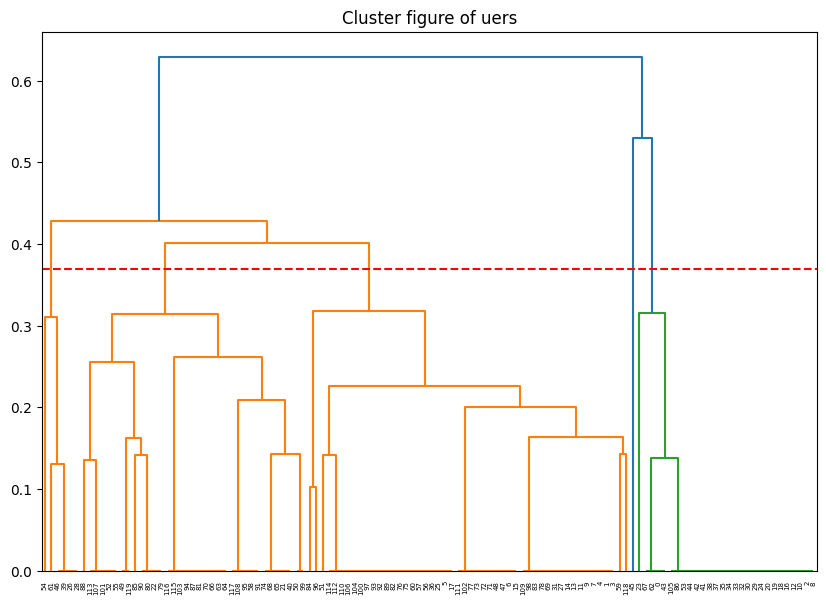

In [7]:
# Decide the best cluster of users
plt.figure(figsize = (10,7))
plt.title('Cluster figure of uers')
dend = shc.dendrogram(shc.linkage(user_scaled[['age','sex','country','city']].values,
                                  method = 'average'))
plt.axhline(y = 0.37,color = 'r', linestyle = '--')
cluster = AgglomerativeClustering(n_clusters = 5)
user['user_cluster'] = cluster.fit_predict(user_scaled[['age','sex','country','city']].values)
pair1 = user[['userID','user_cluster']]
df1 = pd.merge(df, pair1)
user = pd.merge(user,pair1)

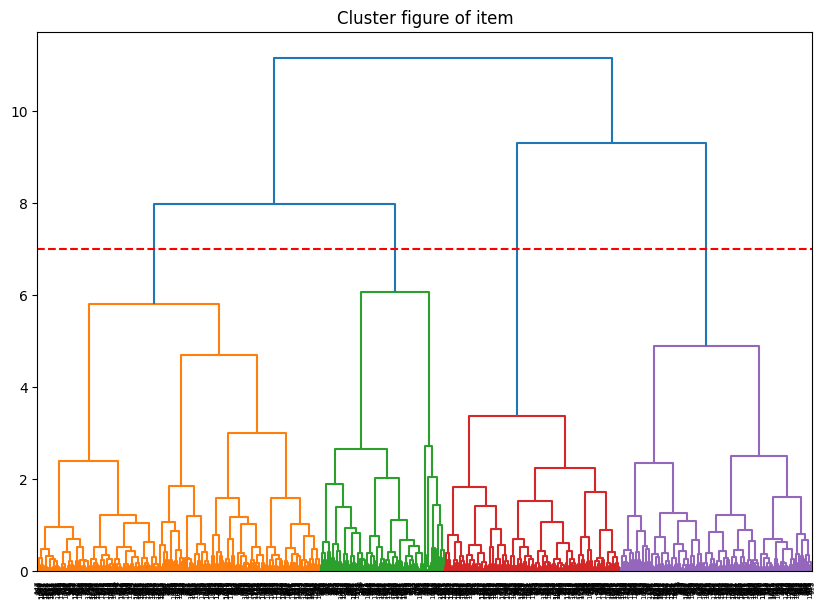

In [8]:
# Decide the best cluster of items
plt.figure(figsize = (10,7))
plt.title('Cluster figure of item')
dend = shc.dendrogram(shc.linkage(item_scaled[['movieCountry','director','movieLanguage','movieYear','genre1','genre2','genre3','actor1','actor2','actor3','budget']].values,
                                  method = 'ward'))
plt.axhline(y = 7,color = 'r', linestyle = '--')
cluster = AgglomerativeClustering(n_clusters = 4)
item['item_cluster'] = cluster.fit_predict(item_scaled[['movieCountry','director','movieLanguage','movieYear','genre1','genre2','genre3','actor1','actor2','actor3','budget']].values)
pair2 = item[['itemID','item_cluster']]
df2 = pd.merge(df, pair2)
item = pd.merge(item,pair2)

In [9]:
df1 = pd.merge(item[['itemID','item_cluster']],df1)
rating = df_explanation[['userID','itemID','rating']]

In [10]:
context = df1.iloc[:,[2,0,30,31, 1,12,16,15]]
user_context_correlation = dict()
context.iloc[:,5:] = context.iloc[:,5:].astype('object')
context_test_user = pd.get_dummies(context)
context_explain = df1.iloc[:,[2,0,30,31, 1,12,16,15]]

<ipython-input-10-795cc6f70ad8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context.iloc[:,5:] = context.iloc[:,5:].astype('object')


In [11]:

social = {'Alone':1,
              'Partner':2,
              'Family':3,
              'Friends':4,
              'Public':5,
              'Parents':6,
              'Colleagues':7}

mood = {'Positive':1,
            'Neutral':2,
            'Negative':3}
physical = {'Healthy':1,
            'Ill':2}


In [12]:
context_explain['social'] = context_explain['social'].map(social)
context_explain['mood'] = context_explain['mood'].map(mood)
context_explain['physical'] = context_explain['physical'].map(physical)

<ipython-input-12-f490e8c8304e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_explain['social'] = context_explain['social'].map(social)
<ipython-input-12-f490e8c8304e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_explain['mood'] = context_explain['mood'].map(mood)
<ipython-input-12-f490e8c8304e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [13]:
context_explain = context_explain.astype('float')
context_explain.iloc[:,5:] = context_explain.iloc[:,5:].astype('object')

In [14]:
context_test_user = pd.get_dummies(context_explain)

<ipython-input-14-048cffb31916>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  context_test_user = pd.get_dummies(context_explain)
<ipython-input-14-048cffb31916>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  context_test_user = pd.get_dummies(context_explain)
<ipython-input-14-048cffb31916>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  context_test_user = pd.get_dummies(context_explain)


In [15]:
def calculate_correlation(context):
    user_context_correlation = dict()
    context_user_correlation = dict()
    item_context_correlation = dict()
    context_item_correlation = dict()
    cluster_context_correlation = dict()
    context_cluster_correlation = dict()
    context_usercluster_correlation = dict()
    usercluster_context_correlation = dict()

    context_test_user = context.copy()

    cluster_set = list(set(context_test_user['userID'].values))
    for cluster in cluster_set:
        user_context_correlation.setdefault(cluster, defaultdict())
        test = context_test_user[context_test_user['userID'] == cluster]
        for context_factor in test.columns[5:]:
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            user_context_correlation[cluster][context_factor] = d2

    for context_factor in context_test_user.columns[5:]:
        context_user_correlation.setdefault(context_factor, defaultdict())
        for cluster in cluster_set:
            test = context_test_user[context_test_user['userID'] == cluster]
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            context_user_correlation[context_factor][cluster] = d2

    cluster_item = list(set(context_test_user['itemID'].values))
    for cluster in cluster_item:
        item_context_correlation.setdefault(cluster, defaultdict())
        test = context_test_user[context_test_user['itemID'] == cluster]
        for context_factor in test.columns[5:]:
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            item_context_correlation[cluster][context_factor] = d2

    for context_factor in context_test_user.columns[5:]:
        context_item_correlation.setdefault(context_factor, defaultdict())
        for cluster in cluster_item:
            test = context_test_user[context_test_user['itemID'] == cluster]
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            context_item_correlation[context_factor][cluster] = d2

    cluster_item = list(set(context_test_user['item_cluster'].values))
    for cluster in cluster_item:
        cluster_context_correlation.setdefault(cluster, defaultdict())
        test = context_test_user[context_test_user['item_cluster'] == cluster]
        for context_factor in test.columns[5:]:
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            cluster_context_correlation[cluster][context_factor] = d2

    for context_factor in context_test_user.columns[5:]:
        context_cluster_correlation.setdefault(context_factor, defaultdict())
        for cluster in cluster_item:
            test = context_test_user[context_test_user['item_cluster'] == cluster]
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            context_cluster_correlation[context_factor][cluster] = d2
    cluster_item = list(set(context_test_user['user_cluster'].values))
    for cluster in cluster_item:
        usercluster_context_correlation.setdefault(cluster, defaultdict())
        test = context_test_user[context_test_user['user_cluster'] == cluster]
        for context_factor in test.columns[5:]:
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            usercluster_context_correlation[cluster][context_factor] = d2

    for context_factor in context_test_user.columns[5:]:
        context_usercluster_correlation.setdefault(context_factor, defaultdict())
        for cluster in cluster_item:
            test = context_test_user[context_test_user['user_cluster'] == cluster]
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            context_usercluster_correlation[context_factor][cluster] = d2
    return user_context_correlation, context_user_correlation, item_context_correlation, context_item_correlation, cluster_context_correlation, context_cluster_correlation,usercluster_context_correlation,context_usercluster_correlation
user_context_correlation, context_user_correlation, item_context_correlation, context_item_correlation, cluster_context_correlation, context_cluster_correlation,usercluster_context_correlation,context_usercluster_correlation = calculate_correlation(context_test_user)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [16]:
def cosine_similarity(x,y):
    x = np.array(x)
    y = np.array(y)
    where1 = np.isnan(x)
    x[where1] = 0.00001
    where2 = np.isnan(y)
    y[where2] = 0.00001
    num = x.dot(y.T)
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    return num / denom
def cal_similarity_context(x,tg):
    x['sim_context'] = None
    for j in x.index:
        x['sim_context'][j] = cosine_similarity(x['context_vector'][tg],x['context_vector'][j])
    return x
def select_local(train_data,i):
    df = train_data.copy()
    context_test_rec = cal_similarity_context(df,i)
    local = context_test_rec[context_test_rec['sim_context'] > 0.5]
    media = local.copy()
    localt = media.drop(index=[i])
    return localt,local
def model_train_for_rec(train_data,i):
    localt,local = select_local(train_data,i)
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(localt[['userID', 'itemID', 'rating']], reader)
    param_grid = {'n_factors': [25, 30, 35, 40],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    algo = gs.best_estimator['rmse']
    algo.fit(data.build_full_trainset())
    return algo,localt,local

In [17]:
context_explain[context_explain['userID'] == 23]

,userID,itemID,rating,user_cluster,item_cluster,social,physical,mood
0,23.0,14.0,5.0,3.0,1.0,1.0,1.0,2.0
18,23.0,18.0,4.0,3.0,1.0,1.0,1.0,2.0
57,23.0,31.0,4.0,3.0,3.0,1.0,1.0,2.0
61,23.0,32.0,3.0,3.0,1.0,1.0,1.0,2.0
831,23.0,3592.0,4.0,3.0,0.0,4.0,1.0,1.0
999,23.0,3675.0,4.0,3.0,1.0,5.0,1.0,1.0
1254,23.0,3783.0,5.0,3.0,1.0,1.0,1.0,2.0


In [18]:
user_dict = dict(zip(pair1['userID'],pair1['user_cluster']))
item_dict = dict(zip(pair2['itemID'],pair2['item_cluster']))

In [20]:
test_try = context_explain.copy()
test_try.iloc[:,5:] = test_try.iloc[:,5:].astype('object')
test_try = pd.get_dummies(test_try)
test_try['context_vector'] = None

for i in test_try.index:
    cluster = test_try['user_cluster'][i]
    test_try['context_vector'][i] = []
    for c in test_try.columns[5:]:
        if test_try[c][i] == 1:
            test_try['context_vector'][i].append(usercluster_context_correlation[cluster][c])



<ipython-input-20-a09e6b71a6a4>:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test_try = pd.get_dummies(test_try)
<ipython-input-20-a09e6b71a6a4>:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test_try = pd.get_dummies(test_try)
<ipython-input-20-a09e6b71a6a4>:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  test_try = pd.get_dummies(test_try)
<ipython-input-20-a09e6b71a6a4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_try['context_vector'][i] = []


In [21]:
def ty(x):
  res = []
  for items in x:
    usadata = usadata_rec.copy()
    context = context_explain.copy()
    for item in items:
      usadata.append(item)
    context.loc[-1] = usadata
    context.iloc[:,5:] = context.iloc[:,5:].astype('object')
    context = pd.get_dummies(context)
    context['context_vector'] = None
    cluster = context['user_cluster'][-1]
    context['context_vector'][-1] = []
    for c in context.columns[5:]:
        if context[c][-1] == 1:
            context['context_vector'][-1].append(usercluster_context_correlation[cluster][c])
    rec_mid = test_try.copy()
    rec_mid.loc[-1] = context.iloc[-1].values
    algo,localt,local = model_train_for_rec(rec_mid,-1)
    rec = algo.predict(usadata[0], usadata[1])
    rec = rec.est
    res.append(rec)
  return np.array(res)


In [45]:
usadata_rec = [23,18,1,3,0]
context_info = [1,	1,	2]
context_info = np.reshape(context_info, (1, len(context_info)))


"\n\nsocial = {'Alone':1,\n              'Partner':2,\n              'Family':3,\n              'Friends':4,\n              'Public':5,\n              'Parents':6,\n              'Colleagues':7}\n\nphysical = {'Healthy':1,\n            'Ill':2}\n\nmood = {'Positive':1,\n            'Neutral':2,\n            'Negative':3}   \n\n                                               \n"

In [54]:
ty(context_info)

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([3.69819269])

In [28]:
train = context_explain.iloc[:,5:]

In [56]:
train.head()

,social,physical,mood
0,1.0,1.0,2.0
1,2.0,1.0,2.0
2,2.0,2.0,2.0
3,2.0,1.0,1.0
4,2.0,1.0,1.0


In [58]:
usadata_rec = [23,18,1,3,0]

In [57]:
'''

social = {'Alone':1,
              'Partner':2,
              'Family':3,
              'Friends':4,
              'Public':5,
              'Parents':6,
              'Colleagues':7}

physical = {'Healthy':1,
            'Ill':2}

mood = {'Positive':1,
            'Neutral':2,
            'Negative':3}


'''

"\n\nsocial = {'Alone':1,\n              'Partner':2,\n              'Family':3,\n              'Friends':4,\n              'Public':5,\n              'Parents':6,\n              'Colleagues':7}\n\nphysical = {'Healthy':1,\n            'Ill':2}\n\nmood = {'Positive':1,\n            'Neutral':2,\n            'Negative':3}   \n\n                                               \n"

In [70]:
train.head()

,social,physical,mood
0,1.0,1.0,2.0
1,2.0,1.0,2.0
2,2.0,2.0,2.0
3,2.0,1.0,1.0
4,2.0,1.0,1.0


In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor wil

Intercept 3.881782578975345
Prediction_local [3.71936471]
Right: 3.725120568014833


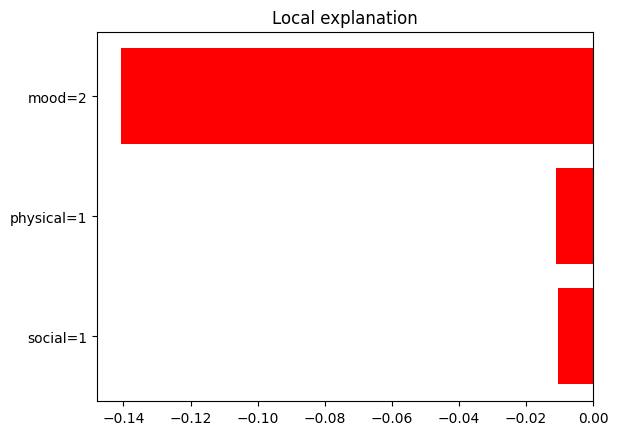

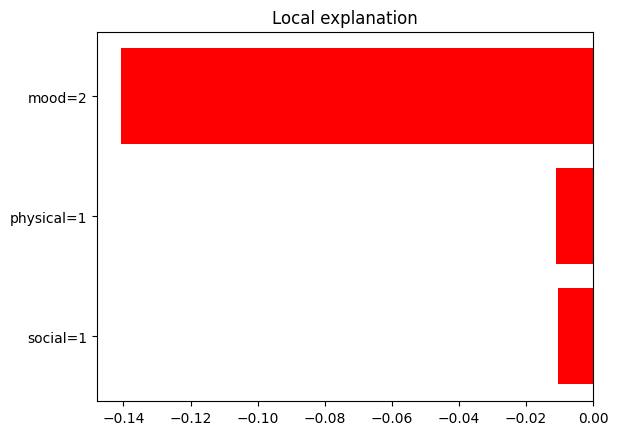

In [68]:
#!pip install lime
import lime
import lime.lime_tabular
train = train.astype('object')

explainer = lime.lime_tabular.LimeTabularExplainer(train.values,
                                                   feature_names=['social', 'physical', 'mood'],
                                                   categorical_features=[0,1,2],
                                                   verbose=True, mode='regression')
exp = explainer.explain_instance(train.iloc[0],
     ty,num_features=3,num_samples=100)
exp.as_pyplot_figure()

In [69]:
exp.as_list()

[('mood=2', -0.1407759339570947),
 ('physical=1', -0.011209829970140474),
 ('social=1', -0.01043210578475539)]

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor wil

Intercept 3.858466673065314
Prediction_local [3.7300375]
Right: 3.71989663928396


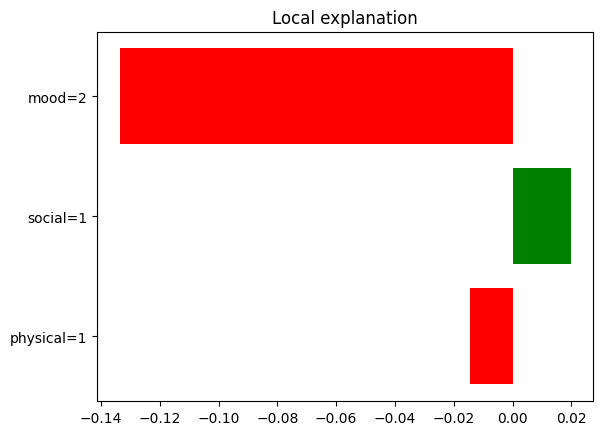

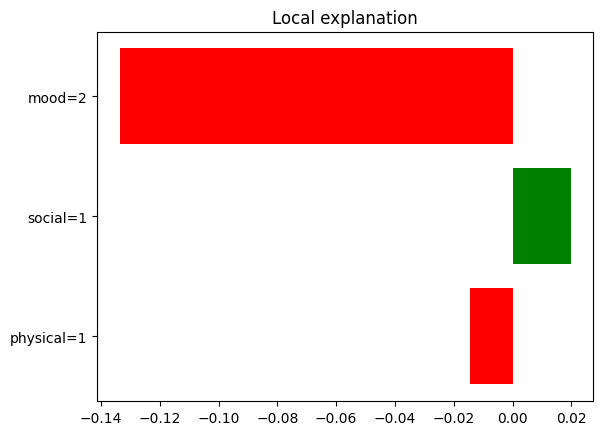

In [71]:
explainer = lime.lime_tabular.LimeTabularExplainer(train.values,
                                                   feature_names=['social', 'physical', 'mood'],
                                                   categorical_features=[0,1,2],
                                                   verbose=True, mode='regression')
exp = explainer.explain_instance(train.iloc[0],
     ty,num_features=3,num_samples=100)
exp.as_pyplot_figure()

In [72]:
exp.as_list()

[('mood=2', -0.13361050800936966),
 ('social=1', 0.019776951613036085),
 ('physical=1', -0.014595617168258407)]

In [31]:
!pip install shap

In [32]:
import shap
summary = shap.kmeans(train, 3)

In [33]:
#summary = train.median().values.reshape((1,train.shape[1]))
explainer1 = shap.KernelExplainer(ty, summary)
shap_values = explainer1.shap_values(train.iloc[:200,:])
np.savetxt('/content/gdrive/My Drive/drive/data/Context/haha_zuinew.txt',shap_values)
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values, train)
print(explainer1.expected_value)

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor wil

  0%|          | 0/200 [00:00<?, ?it/s]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

3.770585534268983


In [34]:
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values, train)

In [65]:
def show_new(j):
  shap.initjs()
  return shap.force_plot(explainer1.expected_value, shap_values[j], train.iloc[j,:])
show_new(0)

In [66]:
train.iloc[0]

social      1.0
physical    1.0
mood        2.0
Name: 0, dtype: object

In [47]:
shap_values[0]

array([ 0.02968767,  0.        , -0.03651919])